# Content-Based Recommendation Engine

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import keyring
import time

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id=keyring.get_password('spotify', 'cid'),
                                                      client_secret=keyring.get_password('spotify', 'secret') )
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## 1. Read the recommendation pool

In [3]:
#read data
chart_tracks_df = pd.read_csv("data/df_charts_tracks_artists.csv")
chart_tracks_df = chart_tracks_df.drop_duplicates(subset='track_id')
chart_tracks_df.head(3)

,Unnamed: 0,date,position,track_id,track_name,artist,streams,artist_id,artist_name,album_id,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,total_followers,genres,artist_popularity
0,0,2018-01-01,1,0ofbQMrRDsUaVKq2mGLEAb,Havana,Camila Cabello,155633,4nDoRrQiYLoBzwC5BhVJzF,Camila Cabello,5chBPOVY2I0bG5V3igb5QL,...,0,0.0312,0.1860,0.000038,0.1040,0.418,104.992,18078605,"['dance pop', 'pop', 'post-teen pop']",87
1,1,2018-01-01,2,0tgVpDi06FyKpA1z0VMD4v,Perfect,Ed Sheeran,134756,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,...,1,0.0232,0.1630,0.000000,0.1060,0.168,95.050,69753264,"['pop', 'uk pop']",93
2,2,2018-01-01,3,3hBBKuWJfxlIlnd9QFoC8k,What Lovers Do (feat. SZA),Maroon 5,130898,04gDigrS5kc9YWfZHwBETP,Maroon 5,1Jmq5HEJeA9kNi2SgQul4U,...,0,0.0671,0.0786,0.000003,0.0855,0.393,110.009,26892218,"['pop', 'pop rock']",90


In [4]:
# #read data
# chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")
# tracks_data_df = pd.read_csv("data/df_charts_tracks_artists.csv")

# #drop duplicates
# tracks_data_df = tracks_data_df.drop_duplicates(subset='track_id')
# tracks_data_df = tracks_data_df[['track_id', 'loudness', 'tempo']]

# #normalize loudness and tempo
# # scaler = MinMaxScaler()
# # chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
# # chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

# chart_tracks_df = pd.merge(chart_tracks_df.drop(['loudness', 'tempo'], 1), tracks_data_df, on='track_id')
# chart_tracks_df.head(3)

In [5]:
chart_tracks_df.shape

(2292, 27)

## 2. Input Seed Track


In [6]:
def get_track_data(t_id):                    
    track_data = sp.track(t_id)
    track_features = sp.audio_features(t_id)
    
    #get only main(first) artist
    td_list = [t_id,\
               track_data['name'],\
               track_data['artists'][0]['id'],\
               track_data['artists'][0]['name'],\
               track_data['album']['uri'].split(":")[2],\
               track_data['duration_ms'],\
               track_data['album']['release_date'],\
               track_data['popularity']]
    data = pd.DataFrame([td_list], columns = ['track_id','track_name','artist_id','artist_name','album_id','duration','release_date','popularity'])

    relevant_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',\
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']  
    
    tf_data = pd.DataFrame(track_features)
    tf_data = tf_data[relevant_cols]
    
    data = pd.concat([data, tf_data], axis=1)
    return data

In [7]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

In [8]:
seed_track_id = input("Enter track id: ")
seed_track_data = get_track_data(seed_track_id)

# seed_track_data['loudness'] = scaler.fit_transform(seed_track_data[['loudness']])
# seed_track_data['tempo'] =  scaler.fit_transform(seed_track_data[['tempo']])

seed_track_data.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,4Oun2ylbjFKMPTiaSbbCih,WAP (feat. Megan Thee Stallion),4kYSro6naA4h99UJvo89HB,Cardi B,2ogiazbrNEx0kQHGl5ZBTQ,187541,2020-08-07,98,0.935,0.454,1,-7.509,1,0.375,0.0194,0,0.0824,0.357,133.073


In [5]:
# feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
#                 'liveness', 'valence', 'tempo']
# genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)

# import pickle

# with open('genre-knn.pkl', 'rb') as file:
#     knn_optimal = pickle.load(file)

# seed_track_data['predicted_genre_id'] = seed_track_data.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
#                                                , axis=1)
# seed_track_data['predicted_genre'] = seed_track_data['predicted_genre_id'].apply(lambda x: genre_lookup[x])
# seed_track_data['predicted_genre_prob'] = seed_track_data.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
#                                                     , axis=1)
# seed_track_data['all_genre_prob'] = seed_track_data.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
#                                                     , axis=1)

## 3. Explore Similarity Measures

In [9]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

Euclidean

In [10]:
chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_id].sort_values('euclidean_dist')[:30]
recommendation_df[['track_id','track_name','artist_name','euclidean_dist']+feature_cols].head(10)

,track_id,track_name,artist_name,euclidean_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
78,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,0.001,0.936,0.523,-6.710,0.0597,0.2390,0.000000,0.1170,0.699,119.889
61531,5vdp5UmvTsnMEMESIF2Ym7,Another One Bites The Dust - Remastered 2011,Queen,0.002,0.933,0.528,-6.472,0.1610,0.1120,0.312000,0.1630,0.754,109.967
71995,6fWTVk29yvFEqE5VY6Gslk,Dalaga,ALLMO$T,0.004,0.939,0.497,-10.441,0.0767,0.5290,0.000091,0.0895,0.588,109.976
48740,2jt2WxXMCD4zjACthkJQVE,The Ringer,Eminem,0.004,0.939,0.551,-9.126,0.2910,0.0311,0.000000,0.1920,0.420,118.552
66198,0Xq3TsWq8bCm7myxpBm0rh,Switch It Up,Lavaado,0.004,0.939,0.463,-9.152,0.4210,0.0723,0.000000,0.0826,0.642,137.051
41574,2E124GmJRnBJuXbTb4cPUB,FEFE (feat. Nicki Minaj & Murda Beatz),6ix9ine,0.004,0.931,0.387,-9.127,0.4120,0.0880,0.000000,0.1360,0.376,125.978
91402,3sm9FJhwOjsdzrfRgIf1ZK,Dalaga,ALLMO$T,0.005,0.940,0.499,-10.123,0.0825,0.5350,0.000119,0.0889,0.537,109.962
93201,3PLARiBoxCpJFUMZhvV63x,Dalaga,ALLMO$T,0.005,0.940,0.499,-10.123,0.0825,0.5350,0.000119,0.0889,0.537,109.962
100,2771LMNxwf62FTAdpJMQfM,Bodak Yellow,Cardi B,0.006,0.929,0.723,-5.792,0.1090,0.0672,0.000000,0.3460,0.458,125.022
165783,5OxveXfvga2t0se21d96Ow,Bored In The House,Tyga,0.007,0.928,0.372,-10.393,0.3210,0.0202,0.000010,0.0948,0.732,112.458


Manhattan

In [11]:
chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  .flatten()[0], axis=1)
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_id].sort_values('manhattan_dist')[:30]
recommendation_df[['track_id','track_name','artist_name','manhattan_dist']+feature_cols].head(10)

,track_id,track_name,artist_name,manhattan_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
78,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,0.001,0.936,0.523,-6.710,0.0597,0.2390,0.000000,0.1170,0.699,119.889
61531,5vdp5UmvTsnMEMESIF2Ym7,Another One Bites The Dust - Remastered 2011,Queen,0.002,0.933,0.528,-6.472,0.1610,0.1120,0.312000,0.1630,0.754,109.967
71995,6fWTVk29yvFEqE5VY6Gslk,Dalaga,ALLMO$T,0.004,0.939,0.497,-10.441,0.0767,0.5290,0.000091,0.0895,0.588,109.976
48740,2jt2WxXMCD4zjACthkJQVE,The Ringer,Eminem,0.004,0.939,0.551,-9.126,0.2910,0.0311,0.000000,0.1920,0.420,118.552
66198,0Xq3TsWq8bCm7myxpBm0rh,Switch It Up,Lavaado,0.004,0.939,0.463,-9.152,0.4210,0.0723,0.000000,0.0826,0.642,137.051
41574,2E124GmJRnBJuXbTb4cPUB,FEFE (feat. Nicki Minaj & Murda Beatz),6ix9ine,0.004,0.931,0.387,-9.127,0.4120,0.0880,0.000000,0.1360,0.376,125.978
91402,3sm9FJhwOjsdzrfRgIf1ZK,Dalaga,ALLMO$T,0.005,0.940,0.499,-10.123,0.0825,0.5350,0.000119,0.0889,0.537,109.962
93201,3PLARiBoxCpJFUMZhvV63x,Dalaga,ALLMO$T,0.005,0.940,0.499,-10.123,0.0825,0.5350,0.000119,0.0889,0.537,109.962
100,2771LMNxwf62FTAdpJMQfM,Bodak Yellow,Cardi B,0.006,0.929,0.723,-5.792,0.1090,0.0672,0.000000,0.3460,0.458,125.022
165783,5OxveXfvga2t0se21d96Ow,Bored In The House,Tyga,0.007,0.928,0.372,-10.393,0.3210,0.0202,0.000010,0.0948,0.732,112.458


Cosine

In [13]:
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

#get top 10 nearest to seed_track_data
# recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:30]
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_id].sort_values('cosine_dist')[:10]
recommendation_df[['track_id','track_name','artist_name','cosine_dist']+feature_cols]

,track_id,track_name,artist_name,cosine_dist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
54359,3JX0dOCIAiaR8MP3ryXWuM,What About Me (feat. Sosamann),Lil Wayne,0.000004,0.785,0.440,-6.566,0.0401,0.02630,0.000002,0.1220,0.220,118.089
20393,2Yl4OmDby9iitgNWZPwxkd,Be Careful,Cardi B,0.000005,0.820,0.568,-8.230,0.4110,0.02560,0.000000,0.0952,0.535,152.279
30518,3qnoOm4fwZPBS116f5hpgF,All Mine,Kanye West,0.000005,0.925,0.308,-6.562,0.3380,0.12500,0.000000,0.0933,0.265,122.099
140987,3yOlyBJuViE2YSGn3nVE1K,My Oh My (feat. DaBaby),Camila Cabello,0.000005,0.724,0.491,-6.024,0.0296,0.01800,0.000013,0.0887,0.383,105.046
162759,3BNwUaRo3w1teVSkd69sL8,Bounty,Ex Battalion,0.000005,0.847,0.584,-7.617,0.0412,0.06440,0.000000,0.0804,0.235,132.009
161185,4EivmOT13NMpNSfTKn9p4s,Like That (feat. Gucci Mane),Doja Cat,0.000005,0.879,0.499,-6.027,0.1800,0.24000,0.000000,0.0967,0.405,106.043
2397,630sXRhIcfwr2e4RdNtjKN,Rewrite The Stars,Zac Efron,0.000006,0.684,0.619,-7.005,0.0386,0.07160,0.000000,0.1220,0.284,125.046
9173,4qKcDkK6siZ7Jp1Jb4m0aL,Look Alive (feat. Drake),BlocBoy JB,0.000006,0.922,0.581,-7.495,0.2700,0.00104,0.000059,0.1050,0.595,140.022
161850,2p8IUWQDrpjuFltbdgLOag,After Hours,The Weeknd,0.000007,0.664,0.572,-6.099,0.0305,0.08110,0.006040,0.1210,0.143,108.959
52,0Zbbxnx4SGGHoIow4PpISP,Stargazing,Kygo,0.000007,0.677,0.497,-5.763,0.0809,0.15200,0.000000,0.0911,0.419,99.137


View histograms of the 3 similarity measures

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027F6FA5C9C8>,
      dtype=object)

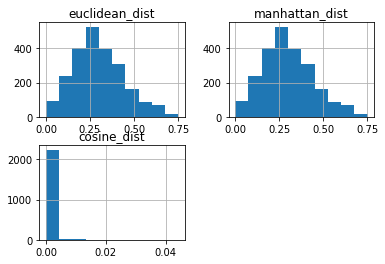

In [160]:
chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

In [13]:
# recommendation_df['artist_name'].to_csv('artists_like_manila_grey.csv')